In [1]:
# imported in order of use
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta

import json
from pprint import pprint
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
sample_companies = pd.read_csv('data/warehouse/sample_companies.csv').set_index('tick')
sample_companies = { tick: cols['CIK'] for tick, cols in sample_companies.iterrows() }
sample_companies = { tick: json.load(open(f'data/sec/companyfacts/CIK{str(cik).zfill(10)}.json')) for tick, cik in sample_companies.items() }
#sample_companies

In [3]:
target_cols = [
    'NetIncomeLoss'
    'OperatingIncomeLoss',
    'OperatingExpenses',
    'InterestExpense',
    'IncomeTaxesPaidNet',
    'DepreciationAndAmortization'
]

In [4]:
def get_column(company_serii: dict, col_name: str, currency: str='USD'):
    time_series = company_serii['facts']['us-gaap'][col_name]['units'][currency]
    column = pd.DataFrame(time_series)
    #column.name = col_name
    return column

In [5]:
pd.set_option('display.max_rows', 256)

In [6]:
operating_result = get_column(sample_companies['MSFT'], 'OperatingIncomeLoss')

operating_result['start'] = pd.to_datetime(operating_result['start'])
operating_result['end'] = pd.to_datetime(operating_result['end'])
operating_result['filed'] = pd.to_datetime(operating_result['filed'])

operating_result['delay'] = operating_result['filed'] - operating_result['end']
operating_result['period'] = operating_result['end'] - operating_result['start']

operating_result = operating_result[ (operating_result.period < timedelta(days=135)) | (operating_result.period > timedelta(days=315)) ]

In [7]:
import plotly.express as plx

In [8]:
quarters = operating_result[ (operating_result.delay < timedelta(days=45)) & (operating_result.period < timedelta(days=135)) ].drop(columns=['frame', 'accn', 'start', 'form']) 
years = operating_result[ (operating_result.delay < timedelta(days=45)) & (operating_result.period > timedelta(days=315)) ].drop(columns=['frame', 'accn', 'start', 'form'])

In [9]:
years[(years.fy == 2012) | (years.fy == 2015)].set_index('fy')

,end,val,fp,filed,delay,period
fy,,,,,,
2012,2012-06-30,21763000000,FY,2012-07-26,26 days,365 days
2015,2015-06-30,18161000000,FY,2015-07-31,31 days,364 days


In [10]:
quarters[(quarters.fy == 2012) | (quarters.fy == 2015)].set_index(['fy', 'fp']).groupby(level='fy').sum()

/tmp/ipykernel_9014/904054831.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  quarters[(quarters.fy == 2012) | (quarters.fy == 2015)].set_index(['fy', 'fp']).groupby(level='fy').sum()


,val
fy,
2012,21571000000
2015,20214000000


In [11]:
# Gets Q4 value from time series as FY - Q3 - Q2 - Q1
fiscal_years = []
for year, fy_data in quarters.groupby('fy'):
    if (fy_data.fp == 'FY').any() or not (years.fy == year).any(): 
        fiscal_years.append(fy_data)
        continue
    year_row = years[years.fy == year].iloc[0]
    q1_row, q2_row, q3_row = fy_data[fy_data.fp == 'Q1'].iloc[0], fy_data[fy_data.fp == 'Q2'].iloc[0], fy_data[fy_data.fp == 'Q3'].iloc[0]
    q4 = {
        'end': [year_row.end],
        'val': [year_row.val - q3_row.val - q2_row.val - q1_row.val],
        'fy': [year_row.fy],
        'fp': ['FY'],
        'filed': [year_row.filed],
        'delay': [year_row.delay],
        'period': [year_row.end - (q3_row.end + timedelta(days=1))],
    }
    fy_data = pd.concat([fy_data, pd.DataFrame(q4)], axis='index')
    fiscal_years.append(fy_data)
    #print(years.set_index('fy').loc[year, 'val'])

In [12]:
final_df: pd.DataFrame = pd.concat(fiscal_years)
final_df['fp'] = final_df.fp.map({'Q1': 'Q1', 'Q2': 'Q2', 'Q3': 'Q3', 'FY': 'Q4'})
final_df.set_index(['fy', 'fp']).sort_index()

end          val      filed   delay  period
fy   fp                                                   
2010 Q1 2009-09-30   4482000000 2009-10-23 23 days 91 days
     Q2 2009-12-31   8513000000 2010-01-28 28 days 91 days
     Q3 2010-03-31   5173000000 2010-04-22 22 days 89 days
     Q4 2010-06-30   5930000000 2010-07-30 30 days 90 days
2011 Q1 2010-09-30   7116000000 2010-10-28 28 days 91 days
     Q2 2010-12-31   8165000000 2011-01-27 27 days 91 days
     Q3 2011-03-31   5709000000 2011-04-28 28 days 89 days
     Q4 2011-06-30   6171000000 2011-07-28 28 days 90 days
2012 Q1 2011-09-30   7203000000 2011-10-20 20 days 91 days
     Q2 2011-12-31   7994000000 2012-01-27 27 days 91 days
     Q3 2012-03-31   6374000000 2012-04-19 19 days 90 days
     Q4 2012-06-30    192000000 2012-07-26 26 days 90 days
2013 Q1 2012-09-30   5308000000 2012-10-18 18 days 91 days
     Q2 2012-12-31   7771000000 2013-01-24 24 days 91 days
     Q3 2013-03-31   7612000000 2013-04-18 18 days 89 days
     Q4 2013-06-30   6073000000 2013-07-30 30 days 90 days
2014 Q1 2013-09-30   6334000000 2013-10-24 24 days 91 days
     Q2 2013-12-31   7969000000 2014-01-23 23 days 91 days
     Q3 2014-03-31   6974000000 2014-04-24 24 days 89 days
     Q4 2014-06-30   6482000000 2014-07-31 31 days 90 days
2015 Q1 2014-09-30   5844000000 2014-10-23 23 days 91 days
     Q2 2014-12-31   7776000000 2015-01-26 26 days 91 days
     Q3 2015-03-31   6594000000 2015-04-23 23 days 89 days
     Q4 2015-06-30  -2053000000 2015-07-31 31 days 90 days
2016 Q1 2015-09-30   5793000000 2015-10-22 22 days 91 days
     Q2 2015-12-31   6026000000 2016-01-28 28 days 91 days
     Q3 2016-03-31   5283000000 2016-04-21 21 days 90 days
     Q4 2016-06-30   3080000000 2016-07-28 28 days 90 days
2017 Q1 2016-09-30   5225000000 2016-10-20 20 days 91 days
     Q2 2016-12-31   6177000000 2017-01-26 26 days 91 days
     Q3 2017-03-31   5594000000 2017-04-27 27 days 89 days
     Q4 2017-06-30   5330000000 2017-08-02 33 days 90 days
2018 Q1 2017-09-30   7708000000 2017-10-26 26 days 91 days
     Q2 2017-12-31   8679000000 2018-01-31 31 days 91 days
     Q3 2018-03-31   8292000000 2018-04-26 26 days 89 days
     Q4 2018-06-30  10379000000 2018-08-03 34 days 90 days
2019 Q1 2018-09-30   9955000000 2018-10-24 24 days 91 days
     Q2 2018-12-31  10258000000 2019-01-30 30 days 91 days
     Q3 2019-03-31  10341000000 2019-04-24 24 days 89 days
     Q4 2019-06-30  12405000000 2019-08-01 32 days 90 days
2020 Q1 2019-09-30  12686000000 2019-10-23 23 days 91 days
     Q2 2019-12-31  13891000000 2020-01-29 29 days 91 days
     Q3 2020-03-31  12975000000 2020-04-29 29 days 90 days
     Q4 2020-06-30  13407000000 2020-07-31 31 days 90 days
2021 Q1 2020-09-30  15876000000 2020-10-27 27 days 91 days
     Q2 2020-12-31  17897000000 2021-01-26 26 days 91 days
     Q3 2021-03-31  17048000000 2021-04-27 27 days 89 days
     Q4 2021-06-30  19095000000 2021-07-29 29 days 90 days
2022 Q1 2021-09-30  20238000000 2021-10-26 26 days 91 days
     Q2 2021-12-31  22247000000 2022-01-25 25 days 91 days
     Q3 2022-03-31  20364000000 2022-04-26 26 days 89 days
     Q4 2022-06-30  20534000000 2022-07-28 28 days 90 days
2023 Q1 2022-09-30  21518000000 2022-10-25 25 days 91 days
     Q2 2022-12-31  20399000000 2023-01-24 24 days 91 days
     Q3 2023-03-31  22352000000 2023-04-25 25 days 89 days
     Q4 2023-06-30  24254000000 2023-07-27 27 days 90 days
2024 Q1 2023-09-30  26895000000 2023-10-24 24 days 91 days

In [13]:
plx.scatter(
    data_frame = quarters ,
    x = 'filed',
    y = 'val',
)

In [14]:
plx.scatter(
    data_frame = years ,
    x = 'filed',
    y = 'val',
)

In [15]:
plx.scatter(
    data_frame = final_df ,
    x = 'filed',
    y = 'val',
)

In [16]:
operating_result.set_index(['fy', 'fp', 'delay']).sort_index()

start        end          val                  accn  \
fy   fp delay                                                               
2010 FY 30 days  2009-07-01 2010-06-30  24098000000  0001193125-10-171791   
        395 days 2008-07-01 2009-06-30  20363000000  0001193125-10-171791   
        760 days 2007-07-01 2008-06-30  22271000000  0001193125-10-171791   
     Q1 23 days  2009-07-01 2009-09-30   4482000000  0001193125-09-212454   
        388 days 2008-07-01 2008-09-30   5999000000  0001193125-09-212454   
     Q2 28 days  2009-10-01 2009-12-31   8513000000  0001193125-10-015598   
        393 days 2008-10-01 2008-12-31   5939000000  0001193125-10-015598   
     Q3 22 days  2010-01-01 2010-03-31   5173000000  0001193125-10-090116   
        387 days 2009-01-01 2009-03-31   4438000000  0001193125-10-090116   
2011 FY 28 days  2010-07-01 2011-06-30  27161000000  0001193125-11-200680   
        393 days 2009-07-01 2010-06-30  24098000000  0001193125-11-200680   
        758 days 2008-07-01 2009-06-30  20363000000  0001193125-11-200680   
     Q1 28 days  2010-07-01 2010-09-30   7116000000  0001193125-10-239825   
        393 days 2009-07-01 2009-09-30   4482000000  0001193125-10-239825   
     Q2 27 days  2010-10-01 2010-12-31   8165000000  0001193125-11-015947   
        392 days 2009-10-01 2009-12-31   8513000000  0001193125-11-015947   
     Q3 28 days  2011-01-01 2011-03-31   5709000000  0001193125-11-115186   
        393 days 2010-01-01 2010-03-31   5173000000  0001193125-11-115186   
2012 FY 26 days  2011-07-01 2012-06-30  21763000000  0001193125-12-316848   
        392 days 2010-07-01 2011-06-30  27161000000  0001193125-12-316848   
        757 days 2009-07-01 2010-06-30  24098000000  0001193125-12-316848   
     Q1 20 days  2011-07-01 2011-09-30   7203000000  0001193125-11-276022   
        385 days 2010-07-01 2010-09-30   7116000000  0001193125-11-276022   
     Q2 27 days  2011-10-01 2011-12-31   7994000000  0001193125-12-026864   
        392 days 2010-10-01 2010-12-31   8165000000  0001193125-12-026864   
     Q3 19 days  2012-01-01 2012-03-31   6374000000  0001193125-12-170665   
        385 days 2011-01-01 2011-03-31   5709000000  0001193125-12-170665   
2013 FY 30 days  2012-07-01 2013-06-30  26764000000  0001193125-13-310206   
        149 days 2012-07-01 2013-06-30  26764000000  0001193125-13-455144   
        395 days 2011-07-01 2012-06-30  21763000000  0001193125-13-310206   
        514 days 2011-07-01 2012-06-30  21763000000  0001193125-13-455144   
        761 days 2010-07-01 2011-06-30  27161000000  0001193125-13-310206   
        880 days 2010-07-01 2011-06-30  27161000000  0001193125-13-455144   
     Q1 18 days  2012-07-01 2012-09-30   5308000000  0001193125-12-427209   
        384 days 2011-07-01 2011-09-30   7203000000  0001193125-12-427209   
     Q2 24 days  2012-10-01 2012-12-31   7771000000  0001193125-13-022207   
        390 days 2011-10-01 2011-12-31   7994000000  0001193125-13-022207   
     Q3 18 days  2013-01-01 2013-03-31   7612000000  0001193125-13-160748   
        383 days 2012-01-01 2012-03-31   6374000000  0001193125-13-160748   
2014 FY 31 days  2013-07-01 2014-06-30  27759000000  0001193125-14-289961   
        396 days 2012-07-01 2013-06-30  26764000000  0001193125-14-289961   
        761 days 2011-07-01 2012-06-30  21763000000  0001193125-14-289961   
     Q1 24 days  2013-07-01 2013-09-30   6334000000  0001193125-13-409855   
        389 days 2012-07-01 2012-09-30   5308000000  0001193125-13-409855   
     Q2 23 days  2013-10-01 2013-12-31   7969000000  0001193125-14-018634   
        388 days 2012-10-01 2012-12-31   7771000000  0001193125-14-018634   
     Q3 24 days  2014-01-01 2014-03-31   6974000000  0001193125-14-157088   
        389 days 2013-01-01 2013-03-31   7612000000  0001193125-14-157088   
2015 FY 31 days  2014-07-01 2015-06-30  18161000000  0001193125-15-272806   
        119 days 2014-07-01 2015-06-30  18161000000  0001193125-15-353706   
        119 days 2

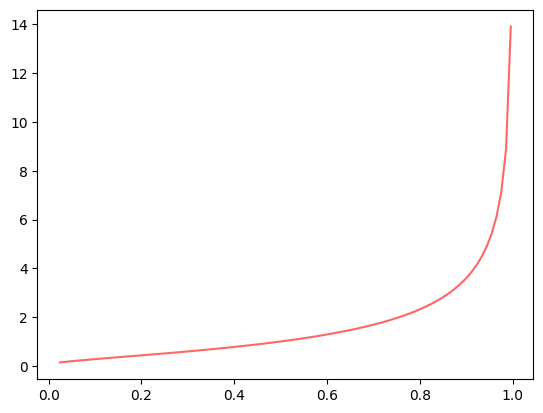

In [17]:
from scipy.stats import lognorm, norm

fig, ax = plt.subplots(1, 1)
s = 1.0

x = np.linspace(lognorm.ppf(0.0001, s),
                lognorm.ppf(0.99, s), 1000)
ax.plot(
    x, 
    lognorm.ppf(x, s),
    'r-', 
    alpha=0.6, 
    label='lognorm ppf'
)

In [18]:
def stochastic_return(mean_log, deviation_log):
    return np.exp(norm.rvs(scale=deviation_log, loc=mean_log, size=8192))

In [19]:
def final_return(weight_a, weight_b, return_a=None, return_b=None, return_0=1):
    weight_0 = 1 - weight_a - weight_b
    if return_a is None:
        return_a = stochastic_return(np.log(1.01), np.log(1.001))
    if return_a is None:
        return_b = stochastic_return(np.log(1.02), np.log(1.01))
    return weight_a*return_a + weight_b*return_b + weight_0*return_0

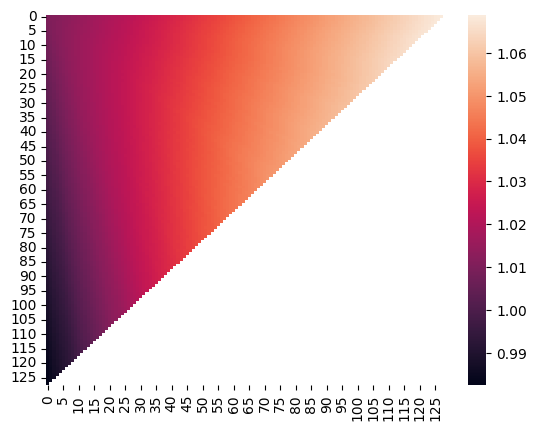

In [20]:
mu_a, sigma_a = np.log(1.2), .05
mu_b, sigma_b = np.log(1.03), .02
risk_factor = 0.01
return_0 = 1.01

return_a, return_b = stochastic_return(mu_a, sigma_a), stochastic_return(mu_b, sigma_b)

quantiles_from_coords = np.vectorize(lambda x, y: np.quantile(final_return(x/127, y/127, return_a, return_b, return_0), risk_factor))

quantile_matrix = np.fromfunction(quantiles_from_coords, (128, 128)).T
#quantile_matrix = [[ (x * y) for x in range(128)] for y in range(128)]
#quantile_matrix = np.array(quantile_matrix)

mask_function = np.vectorize(lambda x, y: (x + y) >= 128)
mask = np.fromfunction(mask_function, (128, 128)).T

graph = sns.heatmap(data=quantile_matrix, mask=mask)